In [1]:
#!/usr/bin/env python3
#coding=utf-8
import time
from Arm_Lib import Arm_Device
import numpy as np
import ikpy.chain

import argparse
import os
import platform
import shutil
import time
from pathlib import Path

import pyrealsense2 as rs
import numpy as np
import cv2

import torch
import torch.backends.cudnn as cudnn
from numpy import random

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import (
    check_img_size, non_max_suppression, apply_classifier, scale_coords, 
    xyxy2xywh, plot_one_box, strip_optimizer, set_logging, xywh2xyxy)
from utils.torch_utils import select_device, load_classifier, time_synchronized
from matplotlib import pyplot as plt

SERVO_SPEED = 3.5
LINK_LIST = [0,30,83,83,80,90]
TOMATO_SIZE = (0.033, 0.037)  # (单位：米)

GRABBER = {
    'open':80,
    'open_leaf':50,
    'close':160,
    'close_leaf':180,
}
DROP_POSITION = [-0.05,-0.2,0.15]
LEAF_POSITION = [-0.05,0.05,0.23]

def read_servolines(Arm):
    angle = []
    time.sleep(0.02)
    for i in range(6):
        aa = Arm.Arm_serial_servo_read(i+1)
        if aa:
            angle.append(aa)
        else:
            angle.append(0)
        time.sleep(.002)
    time.sleep(.002)
    return angle
    


def servo_write(Arm,angle,servo_speed,s_time=None):
    calculate_time = calculate_servotime(Arm,angle,servo_speed)
    # s_time = 1500
    if s_time:
        Arm.Arm_serial_servo_write6(angle[0], angle[1], angle[2], angle[3], angle[4], angle[5], s_time)
        time.sleep(s_time/1000)
        return s_time
    else:
        Arm.Arm_serial_servo_write6(angle[0], angle[1], angle[2], angle[3], angle[4], angle[5], calculate_time)
        time.sleep(calculate_time/1000)
        return calculate_time
    

def calculate_servotime(Arm,target,servo_speed=3):
    servotime = np.array(read_servolines(Arm))-np.array(target)
    return int(max(max(np.abs(servotime)) *servo_speed*5,500))

def one_step(model,pipeline,align,names,img_save=True):
    
    frames = pipeline.wait_for_frames()
    aligned_frames = align.process(frames)
    aligned_depth_frame = aligned_frames.get_depth_frame()
    color_frame = aligned_frames.get_color_frame()
    # 将帧转换为numpy数组
    color_image = np.asanyarray(color_frame.get_data())
    color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
    depth_intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
    device = select_device('')
    # path, img, im0s, vid_cap = LoadStreams(source, img_size=320)
    
    img = torch.tensor(color_image)
    img = np.transpose(img, (2, 0, 1))
    half = device.type != 'cpu'  # half precision only supported on CUDA
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    
    img = img.to(device)
    t1 = time_synchronized()
    pred = model(img, augment=True)[0]

    # Apply NMS
    pred = non_max_suppression(pred, 0.85, 0.2, classes=None, agnostic=True)
    t2 = time_synchronized()

    # Process detections
    img = np.array(img.squeeze(0).cpu())
    img = np.transpose(img, (1, 2, 0))
    img = img * 255
    img = img.astype(np.uint8)
    for i, det in enumerate(pred):  # detections per image
        # Print time (inference + NMS)
        print('Done. ({:.3f}s)'.format((t2 - t1)))    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if det is not None:
        for *xyxy, conf, cls in reversed(det):
            label = '%s %.2f' % (names[int(cls)], conf)
            print(xyxy)
            plot_one_box(xyxy, img, label=label, line_thickness=3)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.show()
    if img_save:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite("a.png",img)
    return det,aligned_depth_frame,depth_intrinsics



def camera_to_world(P_cam, T_cam, R_cam):
    """
    将相机坐标系下的点转换为世界坐标系。
    
    参数：
        P_cam (numpy.array): 相机坐标系下的点 (3x1)。
        T_cam (numpy.array): 相机在世界坐标系中的位置 (3x1)。
        R_cam (numpy.array): 相机的旋转矩阵 (3x3)。
    
    返回：
        numpy.array: 世界坐标系下的点 (3x1)。
    """
    P_world = R_cam @ P_cam + T_cam
    return P_world

def calculate_frame_coor(det,object_index=2):
    res = []
    for i,(*xyxy, conf, cls) in enumerate(det):
        # 番茄=2,叶子=0,茎=1
        if cls == object_index:
            x = int(xyxy[2]-xyxy[0])
            y = int(xyxy[3]-xyxy[1])
            c_x = int((xyxy[0]+ xyxy[2])/2)
            c_y = int((xyxy[1]+ xyxy[3])/2)
            res.append([i,c_x,c_y,x,y,conf,cls])
    return res

def select_tomato():
    # 根据坐标计算得分并选择番茄,现在是用得分最高的
    # 可以用最靠近一侧的番茄
    pass

def control_arm_coor(Arm,my_chain,target_position,grabber,rotation=90,compensate=2):
    converted_position = np.array(target_position)
    print("target coor:",converted_position)
    joints = my_chain.inverse_kinematics(converted_position,initial_position = np.radians([0,90,120,30,40,90,30]))
    joint_list = joints[1:-2]
    print("servos should be",np.degrees(joint_list))
    joint_deg_list = [int(x)for x in np.degrees(joint_list)]
    joint_deg_list.append(rotation)
    joint_deg_list.append(grabber)
    print("The angles of each joints should be:" , joint_deg_list)
    real_frame = my_chain.forward_kinematics(joints)
    error = np.abs(np.linalg.norm(list(real_frame[:3,3]),ord=2)-np.linalg.norm(converted_position,ord=2))
    print("Error:{:.2f}%".format(error*100))
    print("The position is:\n", real_frame)
    if "{:.2f}%".format(error*0.05) != "0.00%":
        print("out of range")
    else:
        print(joint_deg_list)
        if compensate & all([(x - compensate) < 179 for x in joint_deg_list[1:4]]):
            
            joint_deg_list[1:4] = [(x+compensate) for x in joint_deg_list[1:4]]
            print(f"final joint:{joint_deg_list}")
        return servo_write(Arm,joint_deg_list,SERVO_SPEED),joint_deg_list


def object_axis_angle(xyxy,depth_image, padding=5):
    obj_depth_image = depth_image[(xyxy[1]-padding):(xyxy[3]+padding),(xyxy[0]-padding):(xyxy[2]+padding)]
    hist, bin_edges = np.histogram(obj_depth_image,120,range=(100,600))

    min_val = bin_edges[np.argmax(hist)-3]
    max_val = bin_edges[np.argmax(hist)+3]

    mask = (obj_depth_image > min_val) & (obj_depth_image < max_val)
    # 找到 mask 中为 True 的坐标
    y_coords, x_coords = np.where(mask)
    points = np.column_stack((x_coords, y_coords))  # 转换为点集

    # 计算旋转最小包围矩形
    rect = cv2.minAreaRect(points.astype(np.float32))  # (center, (width, height), angle)

    # 提取矩形参数
    (center_x, center_y), (width, height), angle = rect

    # 短轴的倾斜角计算
    if width < height:
        short_axis_angle = (angle + 90)  # 宽是短轴，直接取 angle
    else:
        short_axis_angle = angle  # 高是短轴，角度加 90°
    print("short_axis_angle:",short_axis_angle)
    return short_axis_angle




def object_position(det,aligned_depth_frame,depth_intrinsics,halfsize=0.007,compen = True,object_index = 2):
    res = calculate_frame_coor(det,object_index)
    
    point_list = []
    depth_image = np.asanyarray(aligned_depth_frame.get_data())
    for obj in res:
        *xyxy, conf, cls = det[obj[0]]
        xyxy = [int(x) for x in xyxy]
        depth_value = aligned_depth_frame.get_distance(obj[1], obj[2]) + halfsize
        point = rs.rs2_deproject_pixel_to_point(depth_intrinsics, [obj[1], obj[2]], depth_value)
        axis_angle = object_axis_angle(xyxy,depth_image, padding=20)
        point = [-point[2],point[0],point[1],int(axis_angle)]
        point_list.append(point)
        print(f"Index:{obj[0]}, Pixel: ({obj[1]}, {obj[2]}) -> Point: {point}")
    
    point_list = np.array(point_list)
    

    
    
    
    try:
        filtered_point_list = point_list[point_list[:, 0] > -0.4]

        sorted_point_list = filtered_point_list[np.argsort(filtered_point_list[:, 0])][::-1]
        # 这里只取最近的
        *P_cam,obj_axis_angle = sorted_point_list[0]
    except:
        return None,None
    # 计算旋转矩阵
    T_cam,R_cam = camera_position(Arm,my_chain)

    # 将相机坐标系的点转换为世界坐标系
    P_world = camera_to_world(P_cam, T_cam, R_cam)
    print("Position of the most confident object to be tomato :", np.array(P_world))
    if compen:
        z = P_world[2]
        z = z + (0.35-z)*0.15
        P_world[2] = z
    return np.array(P_world),obj_axis_angle


def camera_position(Arm,my_chain):
    servos = read_servolines(Arm)
    servos = np.radians([0,servos[0],servos[1],servos[2],servos[3],servos[4],servos[5]])
    transformations = my_chain.forward_kinematics(servos, full_kinematics=True)
    servo4_transform = transformations[4]
    
    print(f"关节 {4} 的变换: {servo4_transform},\n坐标:{servo4_transform[:3,3]}")

    camera_offset_z_rotated = np.array([
    [0,  0, -1, 0.04],
    [1,  0,  0, -0.06],
    [0, 1,  0, -0.03],
    [0, 0, 0, 1]
    ])   
    camera_transform = np.dot(servo4_transform, camera_offset_z_rotated)
    camera_position = camera_transform[:3, 3]
    camera_rotation = camera_transform[:3, :3]
    print("摄像头的位置（相对于世界坐标系）：", camera_position)
    return camera_position,camera_rotation


待解决事项（优先度）：

    1. 只抓能抓到的

        a. 通过番茄距离估计该串番茄大概位置范围

        b. 通过检测到的stem计算主干位置

        c. 通过深度图估计番茄是否被遮挡---最可能实现

            提取深度图

    2. 旋转夹子从番茄短轴接近（准备在论文中添加）

        a. 直接在神经网络中标注直接预测

        b. 通过深度图的梯度计算
        
    3. 论文中使用单目估计作为baseline，确认方法的提升
    

In [2]:

my_chain = ikpy.chain.Chain.from_urdf_file("/home/jetson/code/yolov5/yolov5-3.0/arm_real copy.URDF",active_links_mask=[False,True,True,True,True,True,False])
Arm = Arm_Device()
Arm.Arm_serial_set_torque(0)


In [3]:
Arm.Arm_serial_set_torque(1)
servo_write(Arm,[90,90,90,0,90,0],SERVO_SPEED,1500)
# object_position(det,aligned_depth_frame,depth_intrinsics)
camera_position(Arm,my_chain)

关节 4 的变换: [[  -0.017442     0.99924    0.034899 -0.00019628]
 [ 0.00061275   -0.034894     0.99939  1.1016e-05]
 [    0.99985    0.017452 -3.6732e-06     0.27317]
 [          0           0           0           1]],
坐标:[-0.00019628  1.1016e-05     0.27317]
摄像头的位置（相对于世界坐标系）： [  -0.061895   -0.027853     0.31212]


(array([  -0.061895,   -0.027853,     0.31212]),
 array([[    0.99924,    0.034899,    0.017442],
        [  -0.034894,     0.99939, -0.00061275],
        [   0.017452, -3.6732e-06,    -0.99985]]))

In [4]:
# 初始化RealSense管道
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

# 启动管道
pipeline.start(config)
align_to = rs.stream.color
align = rs.align(align_to)

In [184]:
control_arm_coor(Arm,my_chain,[0.00,0.04,0.16],GRABBER['open'])

target coor: [0.   0.04 0.16]
servos should be [1.46527567e-001 1.71887339e+002 4.68707219e-001 1.92938559e-158]
The angles of each joints should be: [0, 171, 0, 0, 90, 80]
Error:3.83%
The position is:
 [[ 9.99996721e-01  3.36534603e-04 -2.53882202e-03 -1.47000083e-04]
 [ 2.56102625e-03 -1.33016333e-01  9.91110537e-01  9.64487291e-02]
 [-4.16180294e-06 -9.91113789e-01 -1.33016759e-01  1.78832276e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[0, 171, 0, 0, 90, 80]


(500, [0, 171, 0, 0, 90, 80])

In [6]:
# target = [135, 96, 29, 22, 90, 150]
# servo_write(Arm,target,SERVO_SPEED)
model = attempt_load('/home/jetson/code/yolov5/yolov5-3.0/0214.pt', map_location=select_device('')).half()  # load FP32 model
# Run inference
img = torch.zeros((1, 3, 640, 640), device=select_device(''))  # init img
_ = model(img.half())
names = ['leaf','stem','tomato',]


Fusing layers... 


In [ ]:

task_list = [[-0.05,0.05,0.28],[-0.05,0.05,0.23],[-0.05,0.05,0.17]] # !!!!!!modify here to set the origin position
while task_list:
    target = task_list[0]
    s_time,target_joint_degree_list = control_arm_coor(Arm,my_chain,target,GRABBER['open'])
    time.sleep(1)
    flag = True

    det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)

    while det is not None and flag :
        flag = False
        position_tomato,rotation = object_position(det,aligned_depth_frame,depth_intrinsics)
        if position_tomato is not None:
            print(position_tomato)
            if control_arm_coor(Arm,my_chain,position_tomato,GRABBER['open'],rotation):
                control_arm_coor(Arm,my_chain,position_tomato,GRABBER['close'],rotation)
                control_arm_coor(Arm,my_chain,target,GRABBER['close'])
                control_arm_coor(Arm,my_chain,DROP_POSITION,GRABBER['close'])
                control_arm_coor(Arm,my_chain,DROP_POSITION,GRABBER['open'])
                control_arm_coor(Arm,my_chain,target,GRABBER['open'])
                flag = True
        time.sleep(1)
        det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)



    print(f"Task on {task_list.pop(0)} is finished")



# Below for debug

Done. (8.770s)
[tensor(185.53125, device='cuda:0', grad_fn=<SelectBackward>), tensor(365.53125, device='cuda:0', grad_fn=<SelectBackward>), tensor(279.96875, device='cuda:0', grad_fn=<SelectBackward>), tensor(485.96875, device='cuda:0', grad_fn=<SelectBackward>)]
[tensor(287.37500, device='cuda:0', grad_fn=<SelectBackward>), tensor(3.62500, device='cuda:0', grad_fn=<SelectBackward>), tensor(483.62500, device='cuda:0', grad_fn=<SelectBackward>), tensor(190.37500, device='cuda:0', grad_fn=<SelectBackward>)]
[tensor(313.28125, device='cuda:0', grad_fn=<SelectBackward>), tensor(296.31250, device='cuda:0', grad_fn=<SelectBackward>), tensor(380.21875, device='cuda:0', grad_fn=<SelectBackward>), tensor(470.18750, device='cuda:0', grad_fn=<SelectBackward>)]
[tensor(151.18750, device='cuda:0', grad_fn=<SelectBackward>), tensor(97.25000, device='cuda:0', grad_fn=<SelectBackward>), tensor(274.31250, device='cuda:0', grad_fn=<SelectBackward>), tensor(258.25000, device='cuda:0', grad_fn=<SelectBack

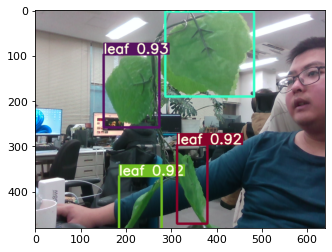

short_axis_angle: 83.9909896850586
Index:0, Pixel: (212, 177) -> Point: [-0.3230000138282776, -0.059824224561452866, -0.03150349482893944, 83]
short_axis_angle: 71.37213897705078
Index:1, Pixel: (346, 383) -> Point: [-0.004999999888241291, 0.0001559851225465536, 0.0011751634301617742, 71]
short_axis_angle: 0.0
Index:2, Pixel: (385, 97) -> Point: [-0.2549999952316284, 0.024016516283154488, -0.05780497193336487, 0]
short_axis_angle: 180.0
Index:3, Pixel: (232, 425) -> Point: [-0.27300000190734863, -0.04174555093050003, 0.08267465233802795, 180]
关节 4 的变换: [[   0.098413     0.70022     0.70711    0.066035]
 [  -0.098408    -0.70023     0.70711   -0.065893]
 [    0.99027    -0.13917 -3.6732e-06     0.20262]
 [          0           0           0           1]],
坐标:[   0.066035   -0.065893     0.20262]
摄像头的位置（相对于世界坐标系）： [  0.0067448   -0.049029     0.25058]
Position of the most confident object to be tomato : [  0.0032383   -0.045302     0.25011]


(array([  0.0032383,   -0.045302,     0.26509]), 71.0)

In [7]:
det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)
object_position(det,aligned_depth_frame,depth_intrinsics,object_index=0)

Done. (4.156s)
[tensor(464., device='cuda:0', grad_fn=<SelectBackward>), tensor(194.25000, device='cuda:0', grad_fn=<SelectBackward>), tensor(641., device='cuda:0', grad_fn=<SelectBackward>), tensor(470.25000, device='cuda:0', grad_fn=<SelectBackward>)]
[tensor(194.37500, device='cuda:0', grad_fn=<SelectBackward>), tensor(273., device='cuda:0', grad_fn=<SelectBackward>), tensor(415.62500, device='cuda:0', grad_fn=<SelectBackward>), tensor(403., device='cuda:0', grad_fn=<SelectBackward>)]


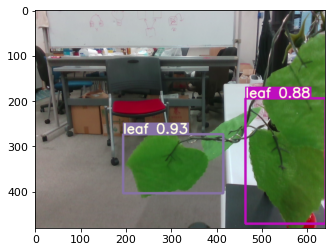

tensor([[194.37500, 273.00000, 415.62500, 403.00000,   0.92933,   0.00000],
        [464.00000, 194.25000, 641.00000, 470.25000,   0.88293,   0.00000]], device='cuda:0', grad_fn=<IndexBackward>) <pyrealsense2.frame Z16 #289192> [ 640x480  p[326.683 237.415]  f[619.191 619.425]  Inverse Brown Conrady [0 0 0 0 0] ]


In [185]:
# One step

frames = pipeline.wait_for_frames()
aligned_frames = align.process(frames)
aligned_depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()
# 将帧转换为numpy数组
color_image = np.asanyarray(color_frame.get_data())
color_image = cv2.cvtColor(color_image, cv2.COLOR_RGB2BGR)
depth_intrinsics = aligned_depth_frame.profile.as_video_stream_profile().intrinsics
device = torch.device('cuda:0')

img = torch.tensor(color_image)
img = np.transpose(img, (2, 0, 1))
half = device.type != 'cpu'  # half precision only supported on CUDA
img = img.half() if half else img.float()  # uint8 to fp16/32
img /= 255.0  # 0 - 255 to 0.0 - 1.0
if img.ndimension() == 3:
    img = img.unsqueeze(0)

img = img.to(device)
t1 = time_synchronized()
pred = model(img, augment=True)[0]

# Apply NMS
pred = non_max_suppression(pred, 0.81, 0.3, classes=None, agnostic=True)
t2 = time_synchronized()

# Process detections
img = np.array(img.squeeze(0).cpu())
img = np.transpose(img, (1, 2, 0))
img = img * 255
img = img.astype(np.uint8)
for i, det in enumerate(pred):  # detections per image
    # Print time (inference + NMS)
    print('Done. ({:.3f}s)'.format((t2 - t1)))    
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if det is not None:
    for *xyxy, conf, cls in reversed(det):
        label = '%s %.2f' % (names[int(cls)], conf)
        print(xyxy)
        plot_one_box(xyxy, img, label=label, line_thickness=3)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)
plt.show()

print(det,aligned_depth_frame,depth_intrinsics)

In [186]:
print(det)
res = calculate_frame_coor(det,object_index=0)
print(res[0])
*xyxy, conf, cls = det[0]
xyxy = [int(x) for x in xyxy]
xyxy

tensor([[194.37500, 273.00000, 415.62500, 403.00000,   0.92933,   0.00000],
        [464.00000, 194.25000, 641.00000, 470.25000,   0.88293,   0.00000]], device='cuda:0', grad_fn=<IndexBackward>)
[0, 305, 338, 221, 130, tensor(0.92933, device='cuda:0', grad_fn=<SelectBackward>), tensor(0., device='cuda:0', grad_fn=<SelectBackward>)]


[194, 273, 415, 403]

target coor: [      -0.07        0.05        0.18]
servos should be [     54.447      171.89      1.8781  9.0612e-09]
The angles of each joints should be: [54, 171, 1, 0, 90, 80]
Error:0.68%
The position is:
 [[    0.58145    0.088352    -0.80877   -0.077215]
 [    0.81358   -0.063148     0.57801    0.055156]
 [-4.0721e-06    -0.99409     -0.1086      0.1832]
 [          0           0           0           1]]
[54, 171, 1, 0, 90, 80]
Done. (0.636s)
[tensor(273.25000, device='cuda:0', grad_fn=<SelectBackward>), tensor(298.43750, device='cuda:0', grad_fn=<SelectBackward>), tensor(427.75000, device='cuda:0', grad_fn=<SelectBackward>), tensor(484.56250, device='cuda:0', grad_fn=<SelectBackward>)]


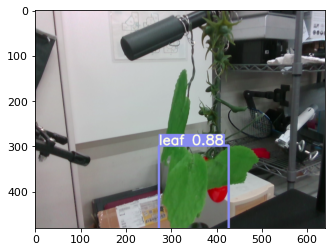

边缘最小深度点: (21, 6)，深度值: 230
原图中的最小深度点像素坐标: (294, 304)
深度值: 0.25300001084804535 m
3D 坐标: [-0.0133542250841856, 0.027196228504180908, 0.25300002098083496]
Index:0, Pixel: (350, 391) -> Point: [-0.0133542250841856, 0.027196228504180908, 0.25300002098083496]
short_axis_angle: 92.43664836883545
point:[-0.25300002098083496, -0.0133542250841856, 0.027196228504180908, 92]
[[     -0.253   -0.013354    0.027196          92]]
关节 4 的变换: [[   -0.11115     0.79086     0.60182    0.056133]
 [   0.083759    -0.59596     0.79864   -0.042198]
 [    0.99027     0.13917 -3.6732e-06     0.20259]
 [          0           0           0           1]],
坐标:[   0.056133   -0.042198     0.20259]
摄像头的位置（相对于世界坐标系）： [   -0.01382   -0.027049     0.23385]
Leaf on task point:[-0.07, 0.05, 0.18] is finished
target coor: [      -0.07        0.05        0.14]
servos should be [     54.447      156.79  2.6405e-10  2.8794e-15]
The angles of each joints should be: [54, 156, 0, 0, 90, 80]
Error:2.25%
The position is:
 [[    0.58

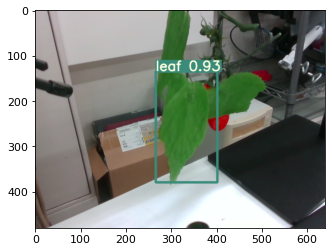

边缘最小深度点: (18, 102)，深度值: 209
原图中的最小深度点像素坐标: (284, 237)
深度值: 0.21700001239776612 m
3D 坐标: [-0.014958590269088745, -0.00014537724200636148, 0.21700000762939453]
Index:0, Pixel: (334, 257) -> Point: [-0.014958590269088745, -0.00014537724200636148, 0.21700000762939453]
short_axis_angle: 99.16234683990479
point:[-0.21700000762939453, -0.014958590269088745, -0.00014537724200636148, 99]
[[     -0.217   -0.014959 -0.00014538          99]]
关节 4 的变换: [[   -0.31205     0.73515     0.60182    0.035029]
 [    0.23515    -0.55397     0.79864   -0.026295]
 [     0.9205     0.39073 -3.6732e-06     0.21619]
 [          0           0           0           1]],
坐标:[   0.035029   -0.026295     0.21619]
摄像头的位置（相对于世界坐标系）： [  -0.039616  -0.0076101     0.22957]
Leaf on task point:[-0.07, 0.05, 0.14] is finished
[[array([   -0.21892,     0.11079,     0.17171]), 92.43664836883545], [array([   -0.20819,     0.10069,     0.14491]), 99.16234683990479]]
target coor: [   -0.20819     0.10069     0.14491]
servos shoul

In [ ]:
import json, time
json_file_path = "/home/jetson/code/data.json"
flag_file_path = "/home/jetson/code/flag.log"
task_list = [[-0.07,0.05,0.18],[-0.07,0.05,0.14],] # !!!!!!modify here to set the origin position
memory_position_leaf = []
padding = 10
while task_list:
    target = task_list[0]
    s_time,target_joint_degree_list = control_arm_coor(Arm,my_chain,target,GRABBER['open'])
    time.sleep(1)
    flag = True

    det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,align,names)


    res = calculate_frame_coor(det,object_index=0)
    point_list = []
    depth_image = np.asanyarray(aligned_depth_frame.get_data())

    for obj in res:
        *xyxy, conf, cls = det[obj[0]]
        xyxy = [int(x) for x in xyxy]
        
        # 3. 找到 mask 的边缘
        try:
            obj_depth_image = depth_image[(xyxy[1]-padding):(xyxy[3]+padding), (xyxy[0]-padding):(xyxy[2]+padding)]
            hist, bin_edges = np.histogram(obj_depth_image, 120, range=(100, 700))
            min_val = bin_edges[np.argmax(hist)-8]
            max_val = bin_edges[np.argmax(hist)+8]

            mask = (obj_depth_image > min_val) & (obj_depth_image < max_val)
            edges = cv2.Canny(mask.astype(np.uint8) * 255, 100, 200)  # Canny 检测边缘
            edge_coords = np.column_stack(np.where(edges > 0))  # 获取边缘像素坐标 (y, x)
            

        # 4. 在边缘上找到深度最小的点
            min_depth = float('inf')
            min_point = None

            for (y, x) in edge_coords:
                depth = obj_depth_image[y, x]
                if depth < min_depth and depth != 0:
                    min_depth = depth
                    min_point = (x, y)  # (x, y) 形式
            print(f"边缘最小深度点: {min_point}，深度值: {min_depth}")
        except:
            pass
        if min_point:
            min_point_original = (min_point[0] + xyxy[0], min_point[1] + xyxy[1])
            print(f"原图中的最小深度点像素坐标: {min_point_original}")

            # **2. 获取该像素的深度值**
            depth_value = aligned_depth_frame.get_distance(min_point_original[0], min_point_original[1]) +0.005
            print(f"深度值: {depth_value} m")

            # **3. 计算真实世界坐标**
            point_3d = rs.rs2_deproject_pixel_to_point(depth_intrinsics, list(min_point_original), depth_value)
            print(f"3D 坐标: {point_3d}")
        else:
            print("未找到有效的最小深度点")
                

        
        print(f"Index:{obj[0]}, Pixel: ({obj[1]}, {obj[2]}) -> Point: {point_3d}")
        axis_angle = object_axis_angle(xyxy,depth_image, padding=0)
        point = [-point_3d[2],point_3d[0],point_3d[1],int(axis_angle)]
        print(f"point:{point}")
        point_list.append(point)

    point_list = np.array(point_list)
    filtered_point_list = point_list[point_list[:, 0] > -0.4]
    print(filtered_point_list)
    sorted_point_list = filtered_point_list[np.argsort(filtered_point_list[:, 0])][::-1]
    # 这里只取最近的
    *P_cam,obj_axis_angle = sorted_point_list[0]
    # 计算旋转矩阵
    T_cam,R_cam = camera_position(Arm,my_chain)

    # 将相机坐标系的点转换为世界坐标系
    P_world = camera_to_world(P_cam, T_cam, R_cam)
    # 保存结果并继续寻找
    memory_position_leaf.append([P_world,axis_angle])
                
    print(f"Leaf on task point:{task_list.pop(0)} is finished")


print(memory_position_leaf)
leaf_drop_position = np.array(memory_position_leaf[-1][0])
leaf_drop_position[2] = leaf_drop_position[2] + 0.1
leaf_drop_position[0] = leaf_drop_position[0] + 0.1


if memory_position_leaf is not None:
    control_arm_coor(Arm,my_chain,memory_position_leaf[-1][0],GRABBER['open_leaf'],obj_axis_angle)
    control_arm_coor(Arm,my_chain,memory_position_leaf[-1][0],GRABBER['close_leaf'],obj_axis_angle)
    control_arm_coor(Arm,my_chain,leaf_drop_position,GRABBER['close_leaf'],obj_axis_angle)
    flag_leave = True
with open(json_file_path, "w") as f:
    json.dump({"Status": "OK"},f)

time.sleep(5)

with open(json_file_path, "w") as f:
    json.dump({"Status": "Awaiting"},f)

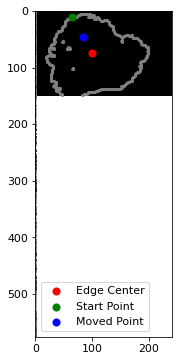

移动后的点: [46 84]
连线的角度（度）: 61.326853510565


([230, 347], 61.326853510565)

In [203]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from collections import deque
# 区域增长算法
def region_growing(h,w,seed,visited,labels,label_id=1,depth_threshold=5,neighbors= [(-1, -1), (-1, 1), (1, -1), (1, 1),(-1, 0), (1, 0), (0, -1), (0, 1)]):
    queue = deque([seed])
    visited[seed[1], seed[0]] = True
    labels[seed[1], seed[0]] = label_id

    while queue:
        cx, cy = queue.popleft()
        current_depth = obj_depth_image[cy, cx]

        for dx, dy in neighbors:
            nx, ny = cx + dx, cy + dy
            if 0 <= ny < h and 0 <= nx < w and not visited[ny, nx]:
                neighbor_depth = obj_depth_image[ny, nx]
                if np.abs(int(current_depth) - int(neighbor_depth)) <= depth_threshold:
                    visited[ny, nx] = True
                    labels[ny, nx] = label_id
                    queue.append((nx, ny))

def leaf_grab_position(depth_image,xyxy,padding = 10,hist_seg = 120,hist_range =(100, 700),depth_threshold = 5,edge_threshold = 2,move_distance = 40):
    """
    depth_image: 深度图;

    xyxy: 叶子boundingbox的xyxy;

    padding:用叶子xyxy裁减深度图后得到的小深度图padding;

    hist_seg:深度图分割区间数;

    hist_range:深度图取值范围;

    depth_threshold:深度图分割物体时阈值;

    edge_threshold:分割边时点与点之间的最大距离;

    move_distanve:按照夹子尺寸，夹子应该向内移动多少；
    """
    # 提取目标区域的深度图
    obj_depth_image = depth_image[(xyxy[1]-padding):(xyxy[3]+padding), (xyxy[0]-padding):(xyxy[2]+padding)]

    # 计算深度直方图
    hist, bin_edges = np.histogram(obj_depth_image, hist_seg,hist_range)

    # 选择最主要的深度区间（最大频数）
    max_bin_idx = np.argmax(hist)
    depth_min = bin_edges[max_bin_idx - 1]
    depth_max = bin_edges[max_bin_idx + 1]

    # 设定高度差阈值

    # 获取目标区域尺寸
    h, w = obj_depth_image.shape

    # 创建标记数组
    visited = np.zeros((h, w), dtype=bool)
    labels = np.zeros((h, w), dtype=np.int32)

    neighbors = [
        (-1, -1), (-1, 1), (1, -1), (1, 1),  # 四个对角线
        (-1, 0), (1, 0), (0, -1), (0, 1)  # 上下左右
    ]

    # 初始化种子点
    center_y, center_x = h // 2, w // 2
    seed = None
    # 搜索种子点（从中心向外扩展）
    for radius in range(max(h, w) // 2):
        for dy in range(-radius, radius + 1):
            for dx in range(-radius, radius + 1):
                y, x = center_y + dy, center_x + dx
                if 0 <= y < h and 0 <= x < w:  # 确保不越界
                    if depth_min <= obj_depth_image[y, x] <= depth_max:
                        seed = (x, y)
                        break
            if seed:
                break
        if seed:
            break


    # 执行连通区域检测
    if seed:
        label_id = 1
        region_growing(h, w,seed,visited,labels,label_id,depth_threshold,neighbors)

    # 计算掩码
    mask = (labels > 0)


    # 计算边缘
    edges = cv2.Canny(mask.astype(np.uint8) * 255, 100, 200)
    # 获取边缘的坐标 (y, x)
    edges_coords = np.column_stack(np.where(edges > 0))

    # 可视化结果
    plt.figure(figsize=(6, 6))
    plt.imshow(edges.astype(np.uint8) * 255, cmap="gray")
    # 设置阈值
    edge_threshold = 2  # 可调整的阈值，用于判断点是否属于同一条边

    # 容器保存所有的边（每条边是一个点的序列）
    edges = []

    # 遍历边缘坐标
    for point in edges_coords:
        added_to_edge = False  # 用来标记该点是否已经加入到某条边中

        # 检查该点和每一条已有的边
        for edge in edges:
            last_point = edge[-1]  # 获取当前边的最后一个点
            # 计算新点和当前边的最后一个点之间的差值
            dy = abs(point[0] - last_point[0])
            dx = abs(point[1] - last_point[1])

            # 如果差值小于等于阈值，将该点加入当前边
            if dy <= edge_threshold and dx <= edge_threshold:
                edge.append(point)
                added_to_edge = True
                break  # 该点已经加入，跳出循环

        # 如果该点没有加入任何一条边，则创建新边
        if not added_to_edge:
            edges.append([point])


    # 筛除只有单个点的边
    edges = [edge for edge in edges if len(edge) > 1]

    # 将大于 20 个点的边拆分成多个不大于 20 个点的子边
    split_edges = []
    for edge in edges:
        for i in range(0, len(edge), 20):  # 每次取20个点
            split_edges.append(edge[i:i + 20])

    # 找到深度值平均值最小的边
    min_avg_depth = float('inf')
    min_avg_depth_edge = None

    for edge in split_edges:
        depths = [obj_depth_image[y, x] for y, x in edge]
        avg_depth = np.mean(depths)
        
        if avg_depth < min_avg_depth:
            min_avg_depth = avg_depth
            min_avg_depth_edge = edge


    # 计算所有边缘点的中心（edges的中心）
    edge_center = np.mean(edges_coords, axis=0).astype(int)

    # 选择边缘上的第一个点作为起点
    start_point = min_avg_depth_edge[0]

    # 计算起始点到边缘中心的向量
    dy = edge_center[0] - start_point[0]
    dx = edge_center[1] - start_point[1]

    # 计算单位向量（方向向量）
    distance = np.sqrt(dy**2 + dx**2)
    unit_vector = np.array([dy, dx]) / distance  # 单位化的方向向量

    # 沿着边缘向中心移动 50 个像素
    move_vector = unit_vector * move_distance
    new_point = start_point + move_vector.astype(int)

    # 计算连线的角度（相对于水平线）
    angle_rad = np.arctan2(dy, dx)  # 计算角度（弧度）
    angle_deg = np.degrees(angle_rad)  # 转换为度

    # 可视化结果
    plt.imshow(edges_coords, cmap="gray")

    # 绘制所有边缘点
    plt.scatter(edges_coords[:, 1], edges_coords[:, 0], color='gray', s=3)  # 所有边缘点

    # 绘制中心点
    plt.scatter(edge_center[1], edge_center[0], color='red', label="Edge Center", s=50)

    # 绘制起始点和新的点（沿边缘移动后的点）
    plt.scatter(start_point[1], start_point[0], color='green', label="Start Point", s=50)
    plt.scatter(new_point[1], new_point[0], color='blue', label="Moved Point", s=50)

    plt.legend()
    plt.show()


    # 输出角度和移动后的点位置
    print(f"移动后的点: {new_point}")
    print(f"连线的角度（度）: {angle_deg}")
    target_point = [new_point[0] - padding + xyxy[0],new_point[1] - padding + xyxy[1]]
    return target_point, angle_deg
leaf_grab_position(depth_image,xyxy)

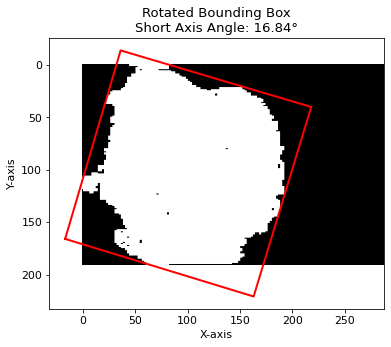

短轴的倾斜角：16.84°


In [176]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 找到 mask 中为 True 的坐标
y_coords, x_coords = np.where(mask)
points = np.column_stack((x_coords, y_coords))  # 转换为点集

# 计算旋转最小包围矩形
rect = cv2.minAreaRect(points.astype(np.float32))  # (center, (width, height), angle)
box = cv2.boxPoints(rect)  # 获取矩形顶点
box = np.int0(box)  # 转换为整数

# 提取矩形参数
(center_x, center_y), (width, height), angle = rect

# 短轴的倾斜角计算
if width < height:
    short_axis_angle = (angle + 90)  # 宽是短轴，直接取 angle
else:
    short_axis_angle = angle  # 高是短轴，角度加 90°

# 绘制原始图像和旋转矩形
plt.figure(figsize=(6, 6))
plt.imshow(mask, cmap="gray", origin="upper")  # 显示原始 mask
plt.plot(
    *np.append(box, [box[0]], axis=0).T,  # 确保闭合
    color="red",
    linewidth=2,
)  # 绘制旋转矩形
plt.title(f"Rotated Bounding Box\nShort Axis Angle: {short_axis_angle:.2f}°")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid(False)
plt.show()

# 输出短轴的倾斜角
print(f"短轴的倾斜角：{short_axis_angle:.2f}°")


In [ ]:
import ikpy.chain
from Arm_Lib import Arm_Device
Arm = Arm_Device()
my_chain = ikpy.chain.Chain.from_urdf_file("/home/jetson/code/yolov5/yolov5-3.0/arm_real.URDF")
degree_list = [0,180,130,40,20,90,30]
servo_write(Arm,degree_list[1:],SERVO_SPEED,s_time = 1500)
angle_test = np.radians(degree_list)
transformations = my_chain.forward_kinematics(angle_test, full_kinematics=True)
for i in range(1, len(transformations)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {transformations[i][:3, 3]}")

In [ ]:
transformations = my_chain.forward_kinematics(angle_test, full_kinematics=True)
for i in range(1, len(transformations)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {transformations[i][:3, 3]}")
angle_test = np.radians([0,90,130,30,0,90,30])
print(transformations[-1][:3,3])
joint_list = list(my_chain.inverse_kinematics(transformations[-1][:3,3],initial_position=angle_test))

print(joint_list)
print([0,0,130,51,19,90,30])
print("solve",np.degrees(joint_list))
real_frame = my_chain.forward_kinematics(joint_list, full_kinematics=True)
for i in range(1, len(real_frame)):  # 忽略起点（索引0）
    print(f"关节 {i} 的位置: {real_frame[i][:3, 3]}")

In [ ]:
joint_list = list(my_chain.inverse_kinematics([-0.05,0,0.35],initial_position=angle_test))
print(np.degrees(joint_list))

In [ ]:
target_position = [-0.05,0,0.35]
grabber = 20
converted_position = np.array(target_position)
print("target coor:",converted_position)
joints = my_chain.inverse_kinematics(converted_position,initial_position = np.radians([0,90,130,20,40,90,30]))
joint_list = joints[1:-1]
print("servos should be",np.degrees(joint_list))
joint_deg_list = [int(x)for x in np.degrees(joint_list)]
joint_deg_list.append(grabber)
print("The angles of each joints should be:" , joint_deg_list)
real_frame = my_chain.forward_kinematics(joints)
error = np.abs(np.linalg.norm(list(real_frame[:3,3]),ord=2)-np.linalg.norm(converted_position,ord=2))
print("Error:{:.2f}%".format(error*100))
print("The position is:\n", real_frame)
if "{:.2f}%".format(error*100) != "0.00%":
    print("out of range")
else:
    servo_write(Arm,joint_deg_list,SERVO_SPEED)

model = detect()
names = ['stem','tomato']
det,aligned_depth_frame,depth_intrinsics = one_step(model,pipeline,names)